In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [421]:
data_23 = pd.read_csv("raw_counts.23.csv", index_col=0)
data_23.loc['Batch_id',:] = [23] * 23 + ['Batch']

data_104 = pd.read_csv("raw_counts.104.csv", index_col=0)
data_104.columns = data_104.columns.str.replace('[ABC]','',regex=True)
data_104.loc['Batch_id',:] = [104] * 104 + ['Batch']
data_104.drop(columns=['Gene.name'], inplace=True)

data_104_new = pd.read_csv("additional_104/raw_counts.csv", index_col=0)
data_104_new.loc['Batch_id',:] = ['104_new'] * 104 + ['Batch']
data_104_new.drop(columns=['Gene.name'], inplace=True)


responses = pd.read_csv('../responses.127.txt', sep="\t", index_col=0)
responses_new = pd.read_csv('../responses_104.txt', sep="\t", index_col=0)
responses = pd.concat([responses, responses_new])
responses = responses.reindex(sorted(responses.index))


protein_coding_genes = pd.read_csv("protein_coding_genes.txt",header=None)
protein_coding_genes.columns = ['Gene.name']
protein_coding_genes.loc[19407,] = 'Batch'

In [422]:
data = pd.concat([data_104, data_23, data_104_new], axis = 1)
data = data.reindex(sorted(data.columns), axis=1)
data = data.merge(protein_coding_genes, how='inner')
data = data.T
data.columns = data.iloc[0,:]
data.drop(data.index[0], inplace=True)
data = data.merge(responses, left_index=True, right_index=True)

In [423]:
data.iloc[:, :data.shape[1]-2] = data.iloc[:, :data.shape[1]-2].astype("int")

C:\Users\ZhanchengZhang\AppData\Local\Temp\ipykernel_16436\956475145.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, :data.shape[1]-2] = data.iloc[:, :data.shape[1]-2].astype("int")


In [424]:
data.columns

Index(['OR4F5', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4',
       'ISG15', 'AGRN', 'RNF223',
       ...
       'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6',
       'MT-CYB', 'Batch', 'Response'],
      dtype='object', length=18751)

In [427]:
data_norm = data.iloc[:,:data.shape[1]-2].T / data.iloc[:,:data.shape[1]-2].quantile(q=0.75, axis=1)*1000

In [428]:
data_norm = data_norm.T
data_norm = data_norm + 1
data_norm = np.log2(data_norm)

In [429]:
data_norm.columns

Index(['OR4F5', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4',
       'ISG15', 'AGRN', 'RNF223',
       ...
       'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=18749)

In [430]:
data_norm[['Batch','Response']] = data[['Batch','Response']]

In [431]:
data_norm.head()

,OR4F5,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,...,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,Batch,Response
HMN1069640,0.0,0.000000,11.607003,9.610080,4.595189,2.827323,1.150243,9.911684,11.246176,1.781999,...,17.814902,16.859475,14.500686,15.149901,17.757676,16.893719,16.055905,16.662596,104_new,High
HMN1069641,0.0,3.633064,11.258371,9.017115,4.973531,4.494816,1.821651,9.608195,10.495188,1.181056,...,17.314252,16.477267,14.172100,14.423535,17.185527,16.592382,15.708867,16.180978,104_new,Medium
HMN1069642,0.0,0.000000,11.203534,8.663538,5.250910,4.917121,0.000000,9.225817,10.382308,3.613055,...,16.971433,16.578920,13.913260,14.451854,17.277483,16.670829,15.816421,16.269275,104_new,High
HMN1075118,0.0,1.286200,11.405030,9.481132,3.802156,1.286200,4.191104,9.484033,11.760747,3.645101,...,17.657191,16.705809,14.390039,15.494018,18.256683,16.876746,15.950875,15.576154,104_new,High
HMN1075119,0.0,1.787006,11.050596,9.617125,5.038381,3.588494,1.154123,9.175439,11.311431,4.740674,...,17.718573,16.732018,14.212112,15.214866,17.760191,16.779264,15.848362,16.605512,104_new,High


In [432]:
data_norm.shape

(231, 18751)

In [433]:
from sklearn.decomposition import PCA

In [475]:
pca = PCA(n_components=10)
pca = pca.fit(data_norm.iloc[:,:data_norm.shape[1]-2])
geneExpression_pca = pca.transform(data_norm.iloc[:,:data_norm.shape[1]-2])

In [476]:
pca.explained_variance_ratio_

array([0.12291415, 0.09373342, 0.06662677, 0.04514373, 0.04134976,
       0.02884447, 0.02498507, 0.02189521, 0.01825732, 0.01573049])

In [478]:
data_norm.columns[0:18749][np.abs(pca.components_[1])>0.01]

Index(['SAMD11', 'ISG15', 'B3GALT6', 'PUSL1', 'CPTP', 'ATAD3C', 'TMEM240',
       'FNDC10', 'MIB2', 'FAAP20',
       ...
       'SIK1', 'CSTB', 'PFKL', 'TRPM2', 'ITGB2', 'SLC19A1', 'COL6A2',
       'SPATC1L', 'LSS', 'S100B'],
      dtype='object', length=3181)

In [479]:
data_norm.shape

(231, 18751)

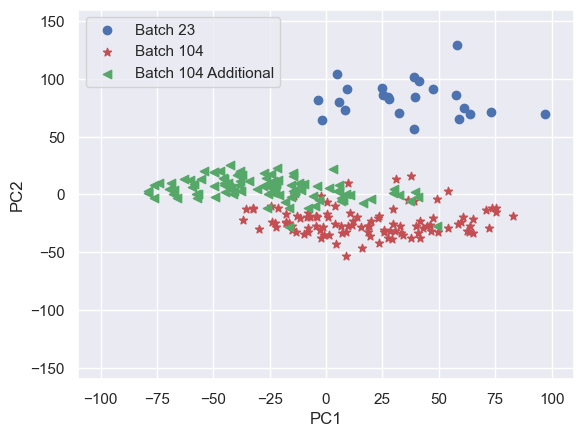

In [602]:
plt.scatter(geneExpression_pca[data_norm['Batch']==23.0,0], geneExpression_pca[data_norm['Batch']==23.0,1], c='b', marker='o',label='Batch 23')
plt.scatter(geneExpression_pca[data_norm['Batch']==104.0,0], geneExpression_pca[data_norm['Batch']==104.0,1], c='r', marker='*', label='Batch 104')
plt.scatter(geneExpression_pca[data_norm['Batch']=='104_new',0], geneExpression_pca[data_norm['Batch']=='104_new',1], c='g', marker='<', label='Batch 104 Additional')
plt.xlim(-110,110)
plt.ylim(-160,160)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend();


In [500]:
data_norm_2 = data_norm.iloc[:,0:18749].loc[:,np.abs(pca.components_[1])<=0.01]

In [501]:
data_norm_2.shape

(231, 15568)

In [502]:
pca_2 = PCA(n_components=10)
pca_2 = pca_2.fit(data_norm_2)
geneExpression_pca_2 = pca_2.transform(data_norm_2)

In [503]:
pca_2.explained_variance_ratio_

array([0.1230301 , 0.0555462 , 0.0516492 , 0.04869738, 0.04507252,
       0.02970789, 0.02607268, 0.02116439, 0.01904045, 0.01529385])

(-140.0, 140.0)

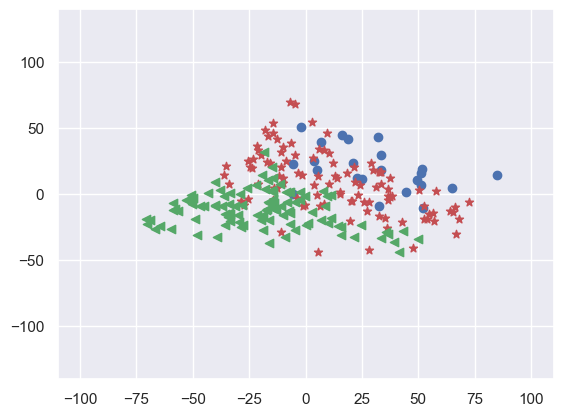

In [504]:
plt.scatter(geneExpression_pca_2[data_norm['Batch']==23.0,0], geneExpression_pca_2[data_norm['Batch']==23.0,1], c='b', marker='o')
plt.scatter(geneExpression_pca_2[data_norm['Batch']==104.0,0], geneExpression_pca_2[data_norm['Batch']==104.0,1], c='r', marker='*')
plt.scatter(geneExpression_pca_2[data_norm['Batch']=='104_new',0], geneExpression_pca_2[data_norm['Batch']=='104_new',1], c='g', marker='<')
plt.xlim(-110,110)
plt.ylim(-140,140)

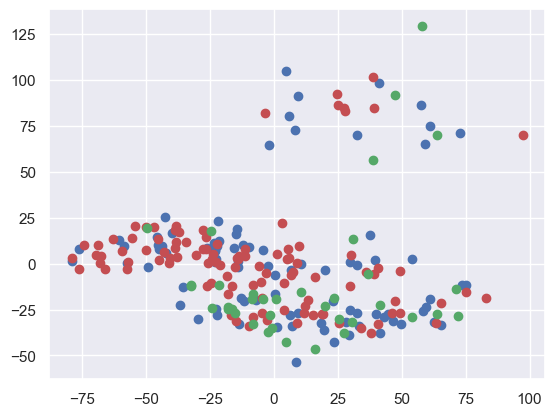

In [509]:
plt.scatter(geneExpression_pca[data_norm['Response']=='Medium',0], geneExpression_pca[data_norm['Response']=='Medium',1], c='b')
plt.scatter(geneExpression_pca[data_norm['Response']=='High',0], geneExpression_pca[data_norm['Response']=='High',1], c='r')
plt.scatter(geneExpression_pca[data_norm['Response']=='Low',0], geneExpression_pca[data_norm['Response']=='Low',1], c='g')

In [524]:
def t_test(row):
    low_group = row[(responses.iloc[:,0] == 'Low') & (data_norm['Batch']==104.0) ].astype('float')
    high_group = row[(responses.iloc[:,0] == 'High') & (data_norm['Batch']==104.0)].astype('float')
    row['mean_low'] = low_group.mean()
    row['mean_high'] = high_group.mean()
    row['log2_fold_change'] = high_group.mean() - low_group.mean()
    row['pvalue_ttest'] = ttest_ind(low_group, high_group).pvalue
    return row

In [536]:
data_norm_T = data_norm.T

In [537]:
data_norm_T.drop(data_norm_T.tail(2).index, inplace=True)

In [538]:
data_norm_T.shape

(18749, 231)

In [539]:
data_norm_T = data_norm_T.apply(t_test, axis=1)

In [540]:
data_norm_T.columns

Index(['HMN1069640', 'HMN1069641', 'HMN1069642', 'HMN1075118', 'HMN1075119',
       'HMN1077914', 'HMN1077915', 'HMN1077916', 'HMN1080358', 'HMN1080359',
       ...
       'LS8847607', 'LS8847675', 'LS8847676', 'LS8848048', 'LS8848348',
       'LS8848489', 'mean_low', 'mean_high', 'log2_fold_change',
       'pvalue_ttest'],
      dtype='object', length=235)

In [541]:
data_norm_T.sort_values('pvalue_ttest', inplace=True)

In [542]:
data_norm_T.dropna(subset=['pvalue_ttest'],inplace=True)

In [543]:
adj = multipletests(data_norm_T['pvalue_ttest'], method='bonferroni')
data_norm_T['pvalue_BF_adjusted'] = adj[1]

In [544]:
adj = multipletests(data_norm_T['pvalue_ttest'], method='fdr_bh')
data_norm_T['pvalue_FDR_adjusted'] = adj[1]

In [545]:
data_norm_T.shape

(18362, 237)

In [546]:
data_norm_T.columns

Index(['HMN1069640', 'HMN1069641', 'HMN1069642', 'HMN1075118', 'HMN1075119',
       'HMN1077914', 'HMN1077915', 'HMN1077916', 'HMN1080358', 'HMN1080359',
       ...
       'LS8847676', 'LS8848048', 'LS8848348', 'LS8848489', 'mean_low',
       'mean_high', 'log2_fold_change', 'pvalue_ttest', 'pvalue_BF_adjusted',
       'pvalue_FDR_adjusted'],
      dtype='object', length=237)

In [547]:
new_index = ['log2_fold_change','mean_low','mean_high','pvalue_ttest', 'pvalue_BF_adjusted', 'pvalue_FDR_adjusted'] + list(data_norm_T.columns[0:231])
data_norm_T = data_norm_T.reindex(new_index, axis=1)

In [549]:
data_norm_T.head()

,log2_fold_change,mean_low,mean_high,pvalue_ttest,pvalue_BF_adjusted,pvalue_FDR_adjusted,HMN1069640,HMN1069641,HMN1069642,HMN1075118,...,LS2427167,LS2427438,LS2427530,LS8847606,LS8847607,LS8847675,LS8847676,LS8848048,LS8848348,LS8848489
SNX18,0.726634,9.070649,9.797283,1.906512e-08,0.000350,0.000350,9.876554,9.498717,9.566631,9.640466,...,9.679860,8.642588,9.731201,9.783171,9.114171,9.162340,8.593376,9.661464,9.760173,9.450911
IL26,2.554166,5.214838,7.769003,6.194754e-08,0.001137,0.000364,6.883537,4.127349,3.856303,6.448421,...,4.910594,4.410766,5.996258,7.813646,7.291826,5.440170,3.794994,4.867218,6.906399,5.904961
STOM,0.719153,10.196192,10.915345,6.496858e-08,0.001193,0.000364,11.309934,10.662465,10.476337,10.350979,...,10.426762,10.580641,10.661764,10.876354,10.525930,9.736715,9.456160,9.979537,10.802021,10.684612
ACTN1,-0.819655,12.356259,11.536604,7.923243e-08,0.001455,0.000364,11.698779,13.021336,12.861150,12.421132,...,12.717843,12.428134,12.662584,11.768384,12.480199,12.163777,12.818245,12.800117,11.800114,12.606562
GLDC,1.786299,4.513736,6.300035,1.159904e-07,0.002130,0.000426,6.236306,4.914126,5.688231,6.159944,...,4.319281,3.859325,5.105278,7.406358,3.771698,6.586700,3.794994,5.842289,7.048222,4.764823


In [552]:
data_norm_T.iloc[:,list(range(0,3))+list(range(6,237))] = data_norm_T.iloc[:,list(range(0,3))+list(range(6,237))].round(4)

In [553]:
data_norm_T.head()

,log2_fold_change,mean_low,mean_high,pvalue_ttest,pvalue_BF_adjusted,pvalue_FDR_adjusted,HMN1069640,HMN1069641,HMN1069642,HMN1075118,...,LS2427167,LS2427438,LS2427530,LS8847606,LS8847607,LS8847675,LS8847676,LS8848048,LS8848348,LS8848489
SNX18,0.7266,9.0706,9.7973,1.906512e-08,0.000350,0.000350,9.8766,9.4987,9.5666,9.6405,...,9.6799,8.6426,9.7312,9.7832,9.1142,9.1623,8.5934,9.6615,9.7602,9.4509
IL26,2.5542,5.2148,7.7690,6.194754e-08,0.001137,0.000364,6.8835,4.1273,3.8563,6.4484,...,4.9106,4.4108,5.9963,7.8136,7.2918,5.4402,3.7950,4.8672,6.9064,5.9050
STOM,0.7192,10.1962,10.9153,6.496858e-08,0.001193,0.000364,11.3099,10.6625,10.4763,10.3510,...,10.4268,10.5806,10.6618,10.8764,10.5259,9.7367,9.4562,9.9795,10.8020,10.6846
ACTN1,-0.8197,12.3563,11.5366,7.923243e-08,0.001455,0.000364,11.6988,13.0213,12.8612,12.4211,...,12.7178,12.4281,12.6626,11.7684,12.4802,12.1638,12.8182,12.8001,11.8001,12.6066
GLDC,1.7863,4.5137,6.3000,1.159904e-07,0.002130,0.000426,6.2363,4.9141,5.6882,6.1599,...,4.3193,3.8593,5.1053,7.4064,3.7717,6.5867,3.7950,5.8423,7.0482,4.7648


In [554]:
data_norm_T.to_csv("differential_GE_104.output.txt",sep="\t")

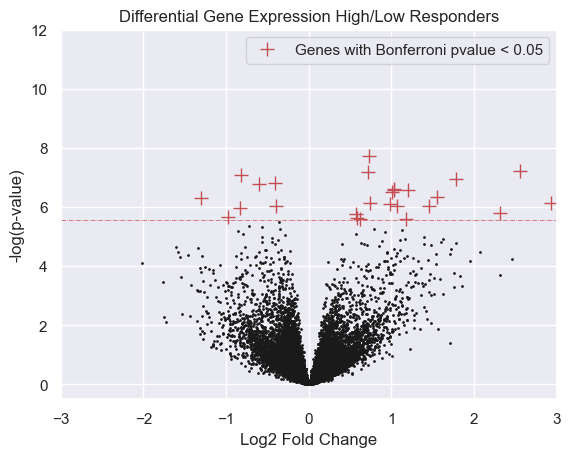

In [556]:
f = plt.figure()
plt.plot(data_norm_T.loc[data_norm_T['pvalue_BF_adjusted'] >= 0.05,'log2_fold_change'], -np.log10(data_norm_T.loc[data_norm_T['pvalue_BF_adjusted'] >= 0.05,'pvalue_ttest']), 'o', color='k', markersize=1)
plt.plot(data_norm_T.loc[data_norm_T['pvalue_BF_adjusted'] < 0.05,'log2_fold_change'], -np.log10(data_norm_T.loc[data_norm_T['pvalue_BF_adjusted'] < 0.05,'pvalue_ttest']), '+', color='r', markersize=10, label="Genes with Bonferroni pvalue < 0.05")
plt.legend()
plt.xlabel("Log2 Fold Change")
plt.ylabel("-log(p-value)")
plt.xlim(-3,3)
plt.ylim(-0.5,12)
plt.axhline(y=-np.log10(2.64e-06), color='r', linestyle='-.',lw=0.5)
plt.title("Differential Gene Expression High/Low Responders")
f.savefig("DE.Volcano.104.png", bbox_inches='tight', dpi=600)

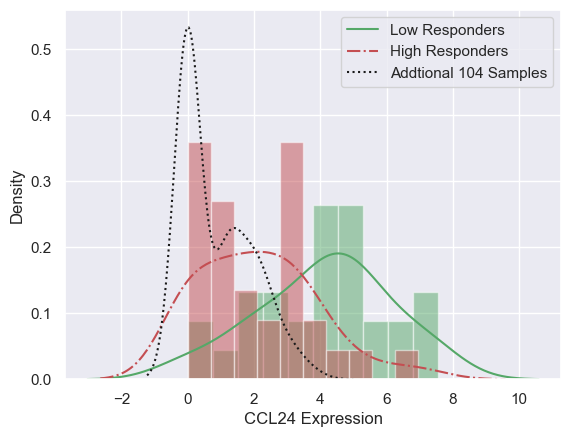

In [600]:
plt.hist(data_norm_T.iloc[:,7:].loc['CCL24',(responses.iloc[:,0] == 'Low') & (data_norm['Batch']==104.0)].T, alpha=0.5, density=T, color='g')
plt.hist(data_norm_T.iloc[:,7:].loc['CCL24',(responses.iloc[:,0] == 'High') & (data_norm['Batch']==104.0)].T, alpha=0.5, density=T, color='r')
sns.kdeplot(data_norm_T.iloc[:,7:].loc['CCL24',list(responses.iloc[:,0] == 'Low') & (data_norm['Batch']==104.0)].T.squeeze(), color='g', label='Low Responders')
sns.kdeplot(data_norm_T.iloc[:,7:].loc['CCL24',list(responses.iloc[:,0] == 'High')& (data_norm['Batch']==104.0)].T.squeeze(),color='r', label='High Responders', linestyle='-.')
sns.kdeplot(data_norm_T.iloc[:,7:].loc['CCL24', data_norm['Batch']=='104_new'].T.squeeze(),color='k', linestyle=':', label="Addtional 104 Samples")
plt.xlabel('CCL24 Expression')
plt.legend()